In [372]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.manifold import TSNE

from matplotlib.lines import Line2D


def load_data_to_df():
    file_path_data = "CATSnDOGS.csv"
    file_path_labels = "Labels.csv"
    delimiter = ","
    df_data = pd.read_csv(file_path_data, delimiter=delimiter, header=0, quotechar='"')
    df_labels = pd.read_csv(
        file_path_labels, delimiter=delimiter, header=0, quotechar='"'
    )
    images = df_data.to_numpy()
    correct_images = [im.reshape(64, 64).T for im in images]
    correct_images = np.array(correct_images)
    flattened_correct_images = [im.flatten() for im in correct_images]
    df = pd.DataFrame(flattened_correct_images)
    df["Label"] = df_labels
    return df


def standardize(train_data, test_data):
    sc = StandardScaler()
    train_data = sc.fit_transform(train_data)
    test_data = sc.transform(test_data)
    return train_data, test_data

In [373]:
df = load_data_to_df()
images = df.iloc[:, :-1]
labels = df["Label"]

In [374]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

X_test_unscaled = X_test.copy().values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression

In [375]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [376]:
from sklearn.feature_selection import SelectFromModel
feature_selector = SelectFromModel(lr_model, threshold='mean')
feature_selector.fit(X_train, y_train)
lr_important_features = np.where(feature_selector.get_support())[0]

In [377]:
lr_coefficients = lr_model.coef_[0]
lr_important_feature_coeffs = lr_coefficients[lr_important_features]
lr_ranked_features = lr_important_features[np.argsort(-np.abs(lr_important_feature_coeffs))]

In [378]:
lr_y_pred = lr_model.predict(X_test)

In [379]:
lr_correct_indices = np.where(lr_y_pred == y_test)[0]
lr_incorrect_indices = np.where(lr_y_pred != y_test)[0]
lr_correct_sample_indices = np.random.choice(lr_correct_indices, 5, replace=False)
lr_incorrect_sample_indices = np.random.choice(lr_incorrect_indices, 5, replace=False)

In [380]:
print(f"Number of important features: {len(lr_important_features)}")

Number of important features: 1733


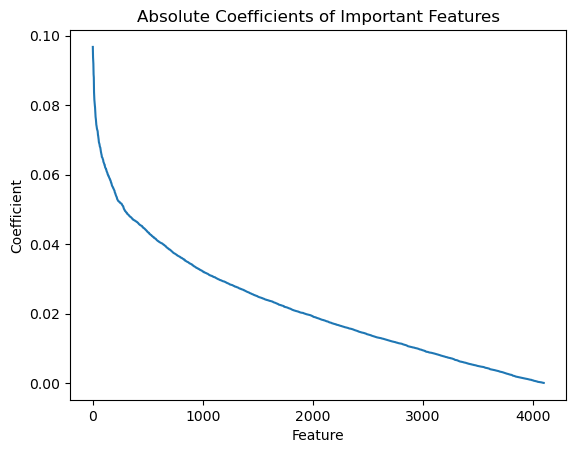

In [399]:
# Plot a line graph of the absolute coefficients of the important features

# Get the list of the most important coefficients
lr_important_coefficients = lr_coefficients[lr_important_features]
lr_important_coefficients = np.abs(lr_important_coefficients)
lr_important_coefficients.sort()
lr_important_coefficients = lr_important_coefficients[::-1]  # Sort in descending order

lr_coefficients = np.abs(lr_coefficients)
lr_coefficients.sort()

# Plot the coefficients
plt.plot(lr_coefficients[::-1])
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.title("Absolute Coefficients of Important Features")
plt.show()

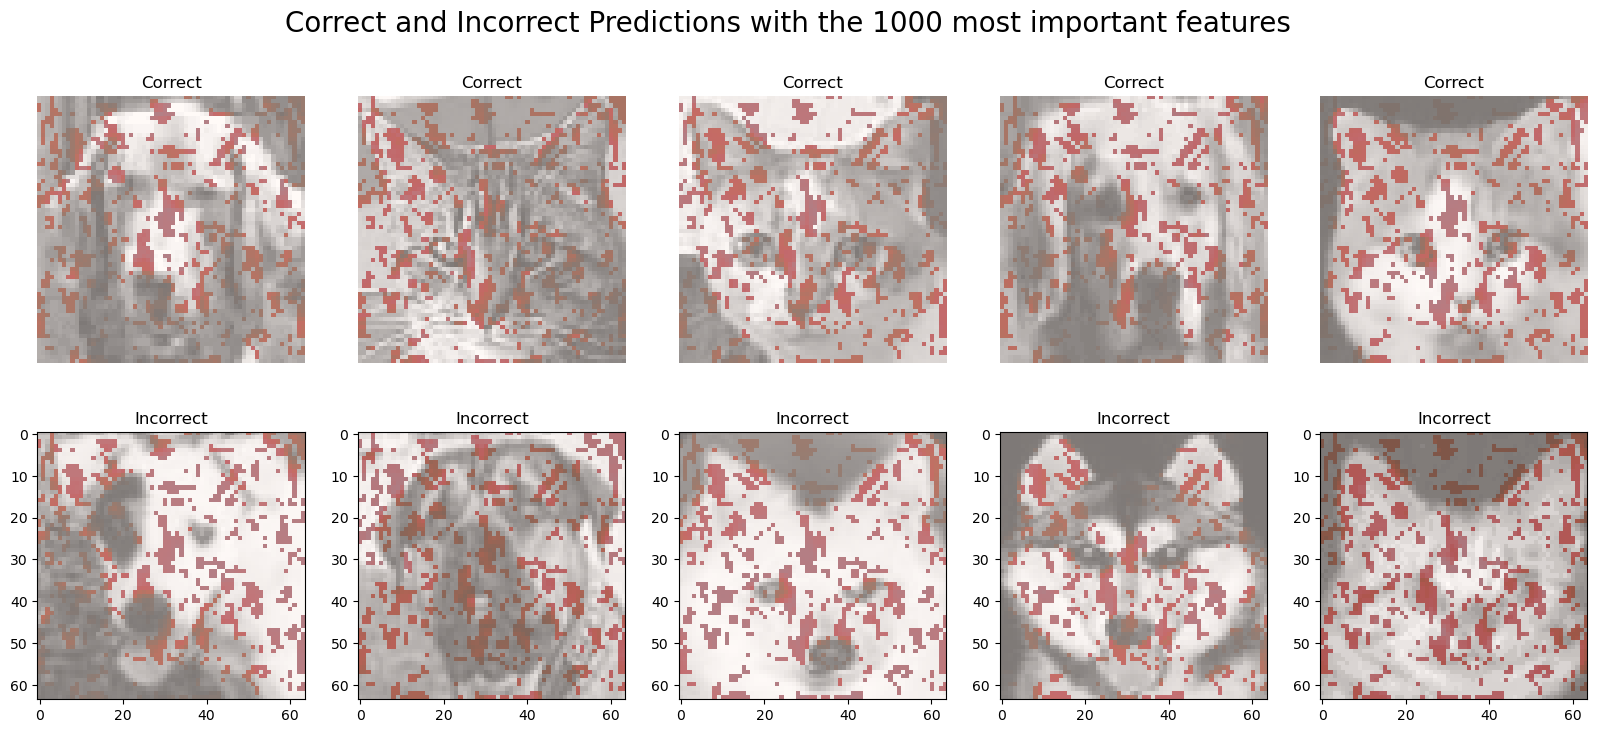

In [382]:
feature_threshold = 1000

fix, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, idx in enumerate(lr_correct_sample_indices):
    image = X_test_unscaled[idx, :]
    reduced_images = np.zeros_like(image)
    reduced_images[lr_ranked_features[:feature_threshold]] = image[
        lr_ranked_features[:feature_threshold]
    ]
    axes[0, i].imshow(image.reshape(64, 64), cmap="gray")
    axes[0, i].imshow(reduced_images.reshape(64, 64), cmap="Reds", alpha=0.5)
    axes[0, i].set_title(f"Correct")
    axes[0, i].axis("off")

for i, idx in enumerate(lr_incorrect_sample_indices):
    image = X_test_unscaled[idx, :]
    reduced_images = np.zeros_like(image)
    reduced_images[lr_ranked_features[:feature_threshold]] = image[
        lr_ranked_features[:feature_threshold]
    ]
    axes[1, i].imshow(image.reshape(64, 64), cmap="gray")
    axes[1, i].imshow(reduced_images.reshape(64, 64), cmap="Reds", alpha=0.5)
    axes[1, i].set_title(f"Incorrect")
    axes[0, i].axis("off")

plt.suptitle(
    f"Correct and Incorrect Predictions with the {feature_threshold} most important features",
    fontsize=20,
)
plt.show()

## SVM

In [383]:
svm = SVC(kernel="linear")
svm.fit(X_train, y_train.values.ravel())

feature_selector = SelectFromModel(svm, threshold='mean')
feature_selector.fit(X_train, y_train)
svm_important_features = np.where(feature_selector.get_support())[0]
svm_important_features = svm_important_features.reshape(-1)

svm_coefs = svm.coef_
svm_abs_coefs = np.abs(svm_coefs)
# svm_important_features = np.argsort(svm_abs_coefs)[::-1]
# svm_important_features = svm_important_features.reshape(-1)

In [384]:
svm_y_pred = svm.predict(X_test)

In [385]:
svm_correct_indices = np.where(svm_y_pred == y_test)[0]
svm_incorrect_indices = np.where(svm_y_pred != y_test)[0]
svm_correct_sample_indices = np.random.choice(svm_correct_indices, 5, replace=False)
svm_incorrect_sample_indices = np.random.choice(svm_incorrect_indices, 5, replace=False)

In [386]:
print(f"Number of important features: {len(svm_important_features)}")

Number of important features: 1724


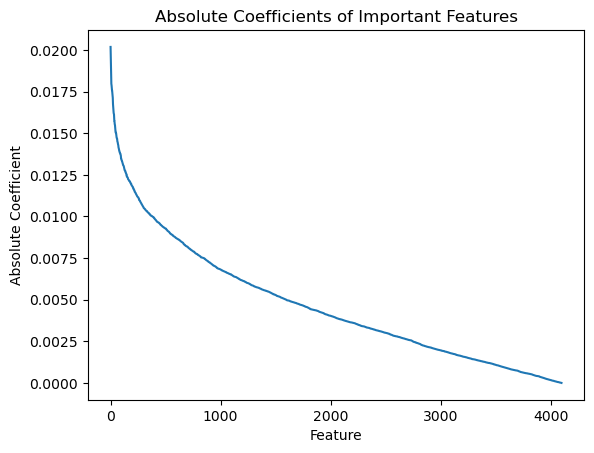

In [387]:
svm_abs_coefs[0].sort()
plt.plot(svm_abs_coefs[0][::-1])
plt.title("Absolute Coefficients of Important Features")
plt.xlabel("Feature")
plt.ylabel("Absolute Coefficient")
plt.show()

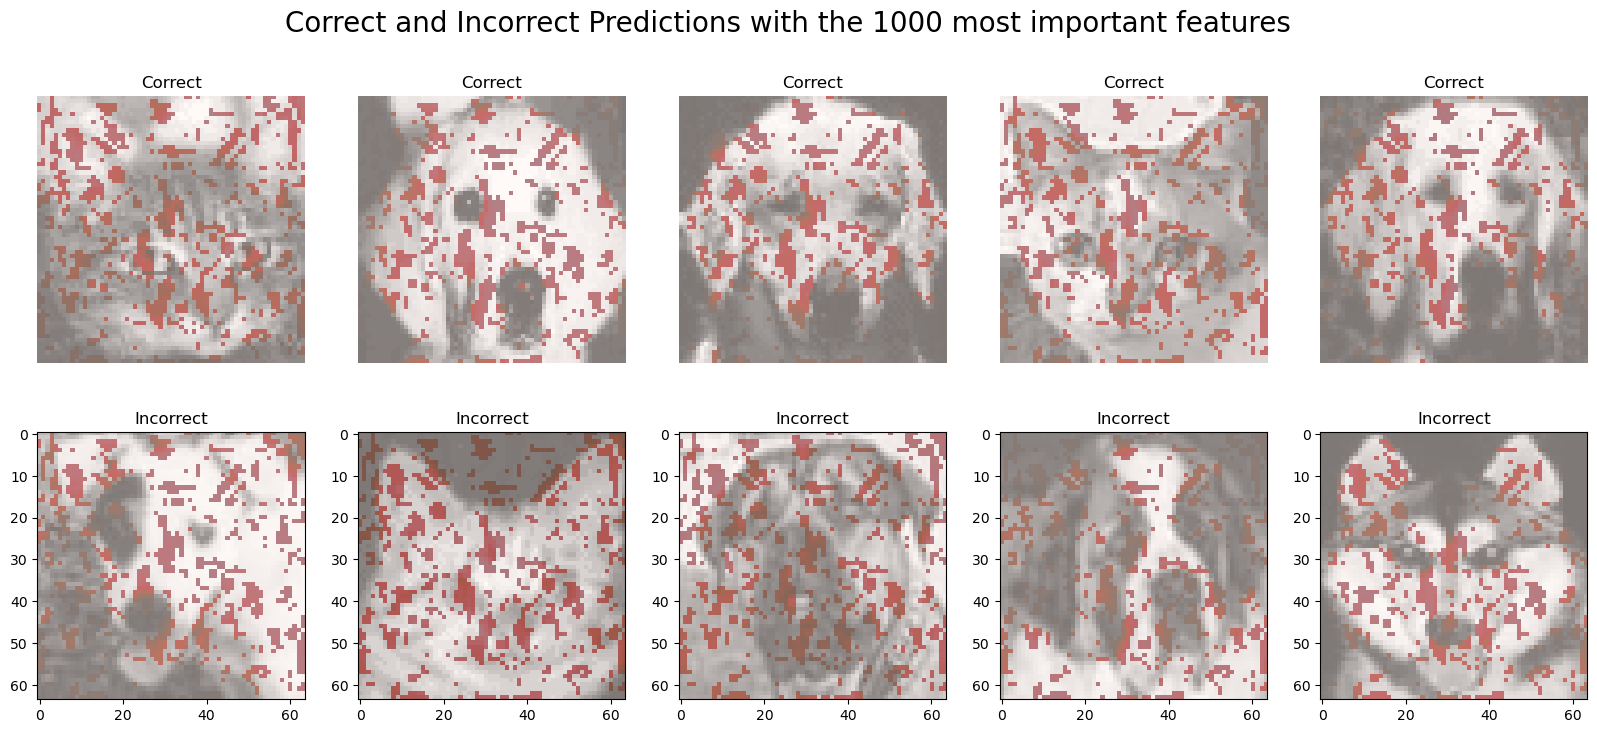

In [388]:
_, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, idx in enumerate(svm_correct_sample_indices):
    image = X_test_unscaled[idx, :]
    reduced_images = np.zeros_like(image)
    reduced_images[lr_ranked_features[:feature_threshold]] = image[
        lr_ranked_features[:feature_threshold]
    ]
    axes[0, i].imshow(image.reshape(64, 64), cmap="gray")
    axes[0, i].imshow(reduced_images.reshape(64, 64), cmap="Reds", alpha=0.5)
    axes[0, i].set_title(f"Correct")
    axes[0, i].axis("off")

for i, idx in enumerate(svm_incorrect_sample_indices):
    image = X_test_unscaled[idx, :]
    reduced_images = np.zeros_like(image)
    reduced_images[lr_ranked_features[:feature_threshold]] = image[
        lr_ranked_features[:feature_threshold]
    ]
    axes[1, i].imshow(image.reshape(64, 64), cmap="gray")
    axes[1, i].imshow(reduced_images.reshape(64, 64), cmap="Reds", alpha=0.5)
    axes[1, i].set_title(f"Incorrect")
    axes[0, i].axis("off")

plt.suptitle(
    f"Correct and Incorrect Predictions with the {feature_threshold} most important features",
    fontsize=20,
)
plt.show()

## Random Forest

In [389]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier()

In [390]:
# Extract feature importance from tree splits
rf_feature_importance = np.zeros(images.shape[1])
for tree in rf.estimators_:
    tree_feature_importance = tree.tree_.compute_feature_importances(normalize=False)
    rf_feature_importance += tree_feature_importance

# Normalize feature importance across trees
rf_feature_importance /= len(rf.estimators_)
rf_important_features = np.argsort(rf_feature_importance)[::-1]

In [391]:
print(f"Number of important features: {len(rf_important_features)}")

Number of important features: 4096


In [392]:
rf_y_pred = rf.predict(X_test)

In [393]:
rf_correct_indices = np.where(rf_y_pred == y_test)[0]
rf_incorrect_indices = np.where(rf_y_pred != y_test)[0]
rf_correct_sample_indices = np.random.choice(rf_correct_indices, 5, replace=False)
rf_incorrect_sample_indices = np.random.choice(rf_incorrect_indices, 5, replace=False)

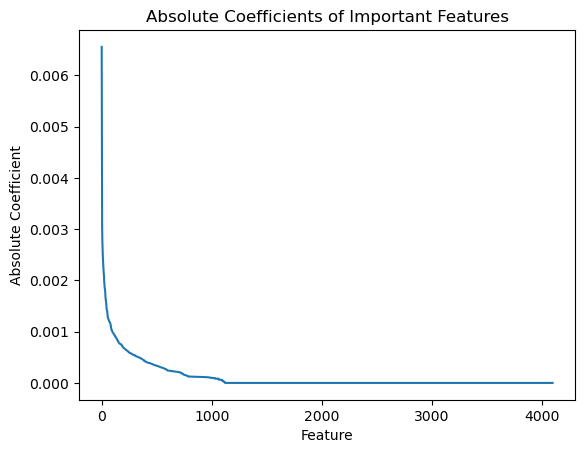

In [394]:
rf_feature_importance.sort()
plt.plot(rf_feature_importance[::-1])
plt.title("Absolute Coefficients of Important Features")
plt.xlabel("Feature")
plt.ylabel("Absolute Coefficient")
plt.show()

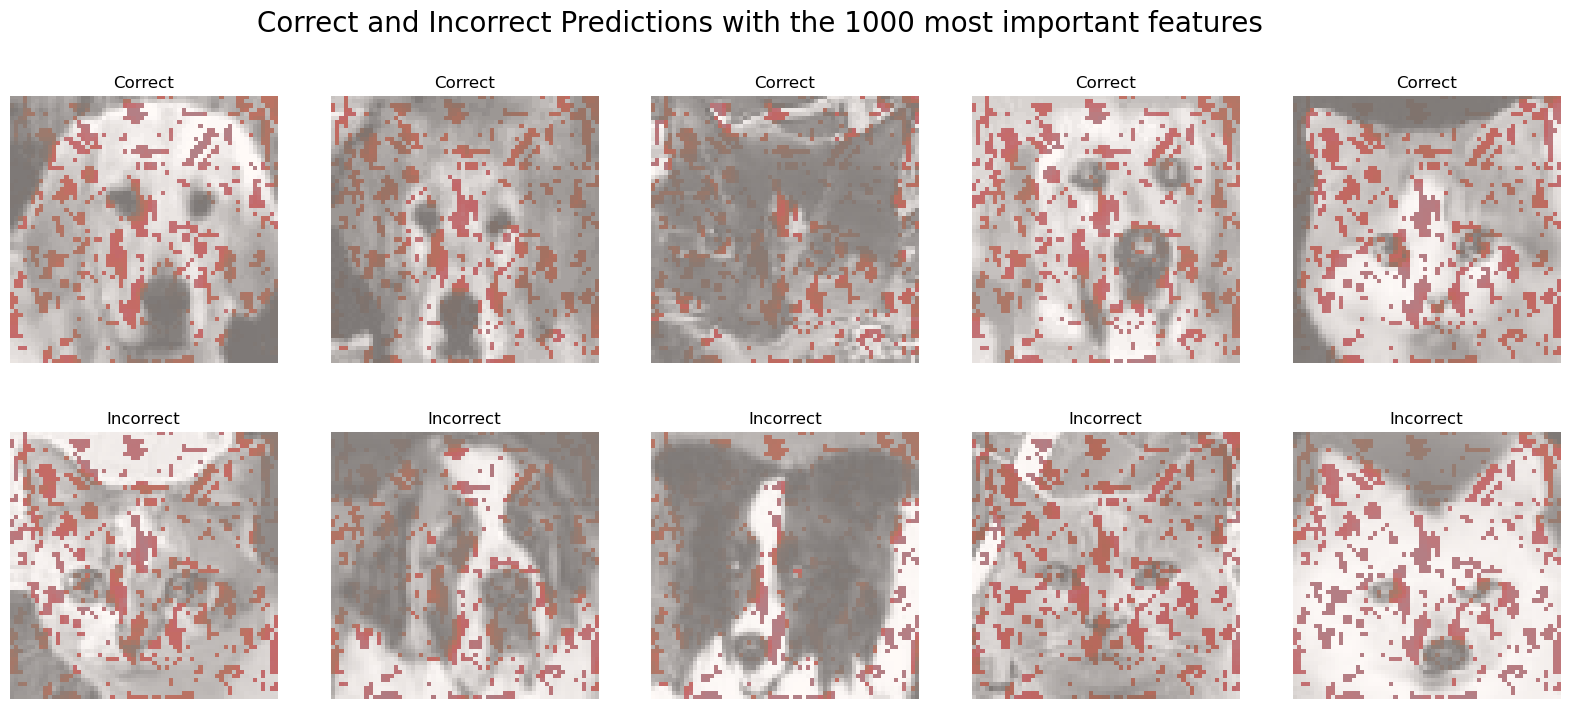

In [395]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, idx in enumerate(rf_correct_sample_indices):
    image = X_test_unscaled[idx, :]
    reduced_images = np.zeros_like(image)
    reduced_images[lr_ranked_features[:feature_threshold]] = image[
        lr_ranked_features[:feature_threshold]
    ]
    axes[0, i].imshow(image.reshape(64, 64), cmap="gray")
    axes[0, i].imshow(reduced_images.reshape(64, 64), cmap="Reds", alpha=0.5)
    axes[0, i].set_title(f"Correct")
    axes[0, i].axis("off")

for i, idx in enumerate(rf_incorrect_sample_indices):
    image = X_test_unscaled[idx, :]
    reduced_images = np.zeros_like(image)
    reduced_images[lr_ranked_features[:feature_threshold]] = image[
        lr_ranked_features[:feature_threshold]
    ]
    axes[1, i].imshow(image.reshape(64, 64), cmap="gray")
    axes[1, i].imshow(reduced_images.reshape(64, 64), cmap="Reds", alpha=0.5)
    axes[1, i].set_title(f"Incorrect")
    axes[1, i].axis("off")

plt.suptitle(
    f"Correct and Incorrect Predictions with the {feature_threshold} most important features",
    fontsize=20,
)
plt.show()